# Introduction to Neural Networks: Bank Churn prediction

## Problem Statement

### Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary:

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer
 
* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location 
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer 
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary 

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values 
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

#### Some notes
- Recall would be the best metric to optimize for
- Use stratify for train_test_split
- Ensure that ROC-AUC is used to identify probability split for classification

## Importing necessary libraries

In [149]:
import pandas as pd
import numpy as np

# import libraries for pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# import libraries for data imputation
from sklearn.impute import SimpleImputer

from sklearn import model_selection
from sklearn.compose import ColumnTransformer

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import libraries for model scoring
from sklearn.metrics import confusion_matrix

# import libraries for standardization and automation of modeling
from sklearn.pipeline import Pipeline

# import libraries for model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# import libraries for NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import random
from tensorflow.keras import backend

# import libraries for warnings - set random seeds
import warnings
random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

## Loading the dataset

In [460]:
# import churn dataset, store in df
df = pd.read_csv('datasets/Churn.csv')

# run head to validate ingestion of data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Overview

In [442]:
# run shape, info, describe to get basic understanding of data
df.shape 

(10000, 14)

In [4]:
# run info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# run dtype to verify data types of the dataset
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
# run describe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [7]:
# run sanity check on duplicate data
df.duplicated().sum()

0

In [8]:
# run sanity check on missing data
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
# run value counts against Exited to understan splits/percentages
df.Exited.value_counts(1)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

### Initial Findings Data Overview
- 10,000 rows and 14 columns
- There are no duplicated rows
- There is no missing data, or at least no null values in the data
- There are 11 columns or features that are numerical
- There are 3 columns or features that are objects/categorical
- Exited is the target variable and is already set to numerical 0 or 1
- 79.6% Exited = 0 is "No did not exit"
- 20.4% Exited = 1 is "Yes exited"
- RowNumber, CustomerID, and Surname can most likely be dropped from the dataset

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of the credit score of customers? Are there any noticeable patterns or outliers in the distribution?
- There is a maximum score for credit score. Therefore you will see a larger number of people with the max score than a score that is 10 points less
2. How many active members are there with the bank?
- There are 5,151 active members of the bank
3. How are the different customer attributes correlated to each other?
- The correlation matrix doesn't indicate there are strong positive or negative correlations
4. Who is churning more when compared to males and females? 
- Female 1139 churned 
- Male  898 churned 
5. Customers from which geographical part are churning more?
- Geography
- Germany 814 churned
- France 810 churned
- Spain 413 churned

In [10]:
# identify how many unique customer ids there are
df.CustomerId.nunique()

# how many active members
df.IsActiveMember.value_counts()

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

In [11]:
# function to plot a boxplot and a histogram along the same scale.
# define a function for unvariate analysis


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="lightblue"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.text(x = data[feature].mean(),
        y = max([h.get_height() for h in ax_hist2.patches]),
        s = 'mean: {:,.1f}'.format(data[feature].mean()),
        color = 'darkgreen'
    ) # Add mean label to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    ax_hist2.text(x = data[feature].median(),
        y = max([h.get_height()-50 for h in ax_hist2.patches]),
        s = 'median: {:,.1f}'.format(data[feature].median()),
        color = 'purple'
    ) # Add median label to the histogram

In [12]:
# RowNumber            int64 DROP
# CustomerId           int64 DROP
# Surname             object DROP
# CreditScore          int64 UNI, BI
# Geography           object CAT, BI
# Gender              object CAT, BI
# Age                  int64 UNI, BI
# Tenure               int64 UNI, BI
# Balance            float64 UNI, BI
# NumOfProducts        int64 UNI, BI
# HasCrCard            int64 UNI, BI
# IsActiveMember       int64 UNI, BI
# EstimatedSalary    float64 UNI
# Exited               int64

### Univariate Analysis

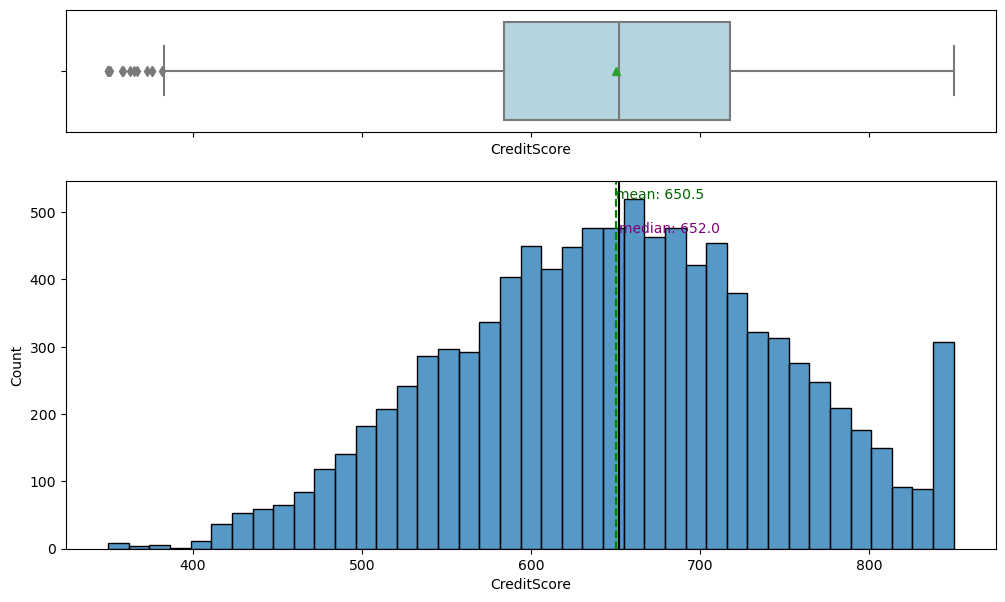

In [13]:
# run histogram_boxplot against numerical data in the dataset
# CreditScore
histogram_boxplot(df, 'CreditScore')

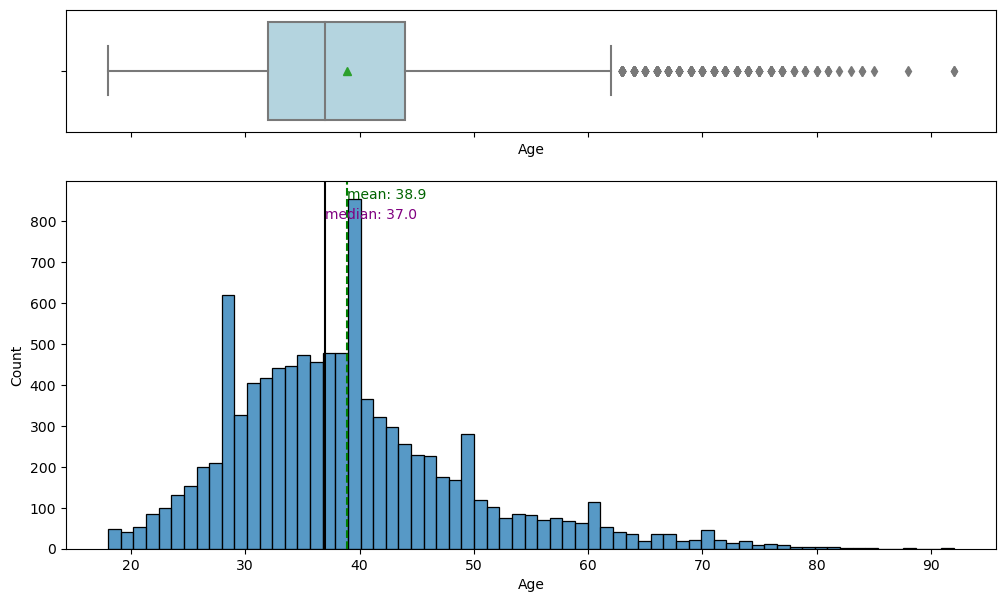

In [14]:
# run histogram_boxplot against numerical data in the dataset
# Age
histogram_boxplot(df, 'Age')

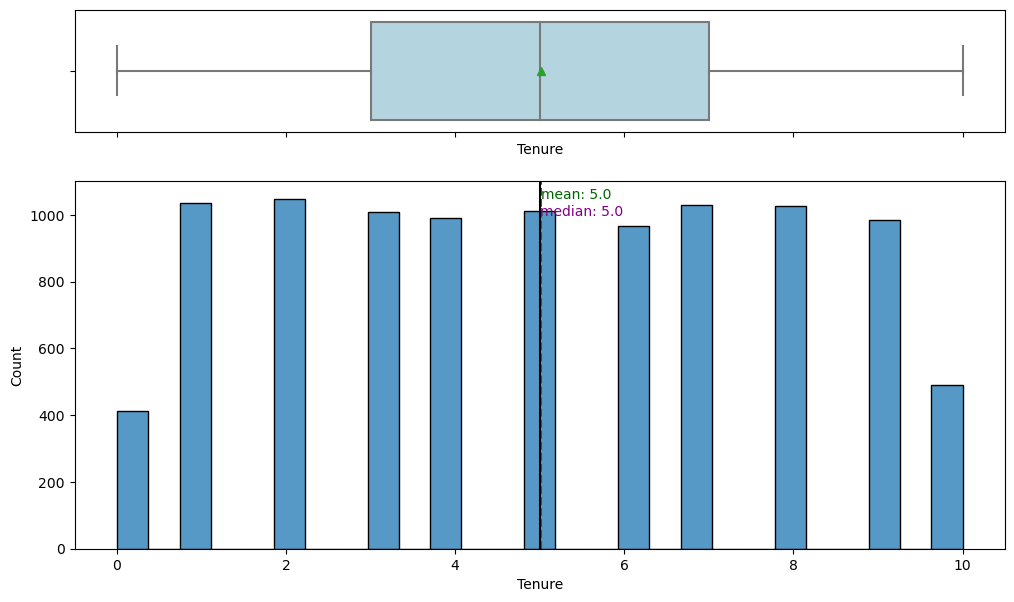

In [15]:
# run histogram_boxplot against numerical data in the dataset
# Tenure
histogram_boxplot(df, 'Tenure')

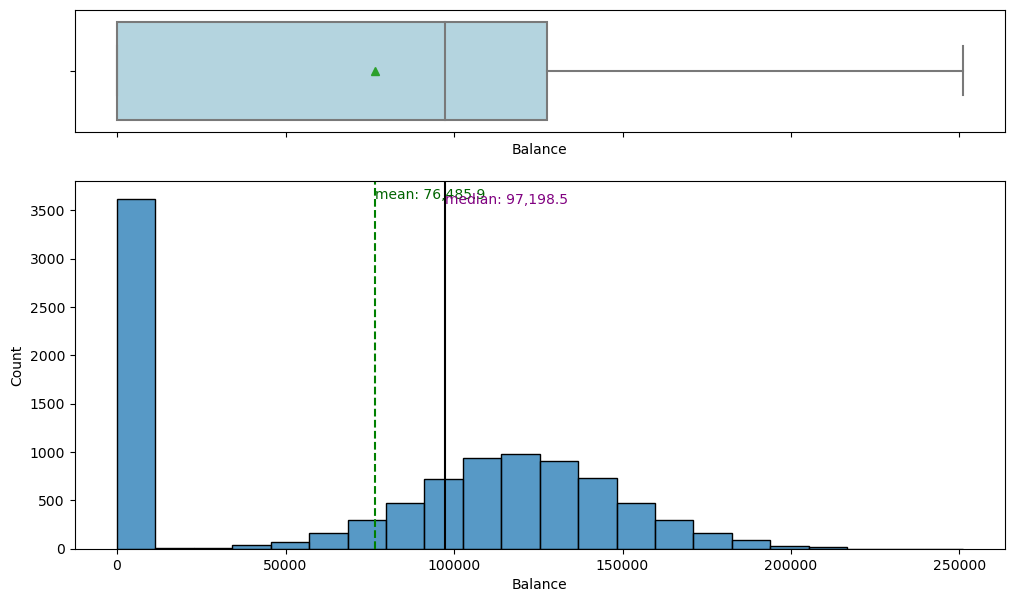

In [16]:
# run histogram_boxplot against numerical data in the dataset
# Balance
histogram_boxplot(df, 'Balance')

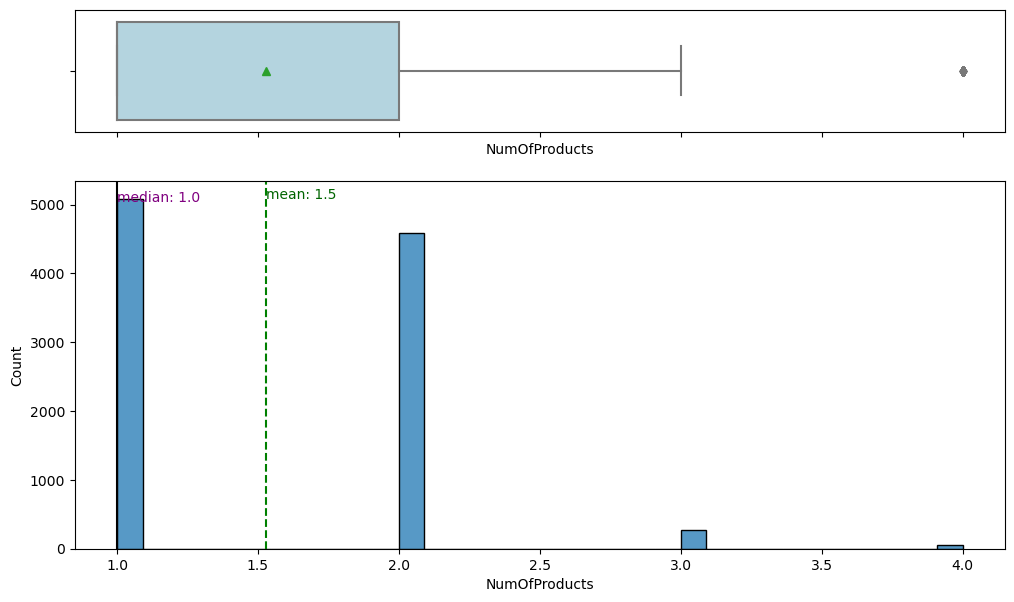

In [17]:
# run histogram_boxplot against numerical data in the dataset
# NumOfProducts
histogram_boxplot(df, 'NumOfProducts')

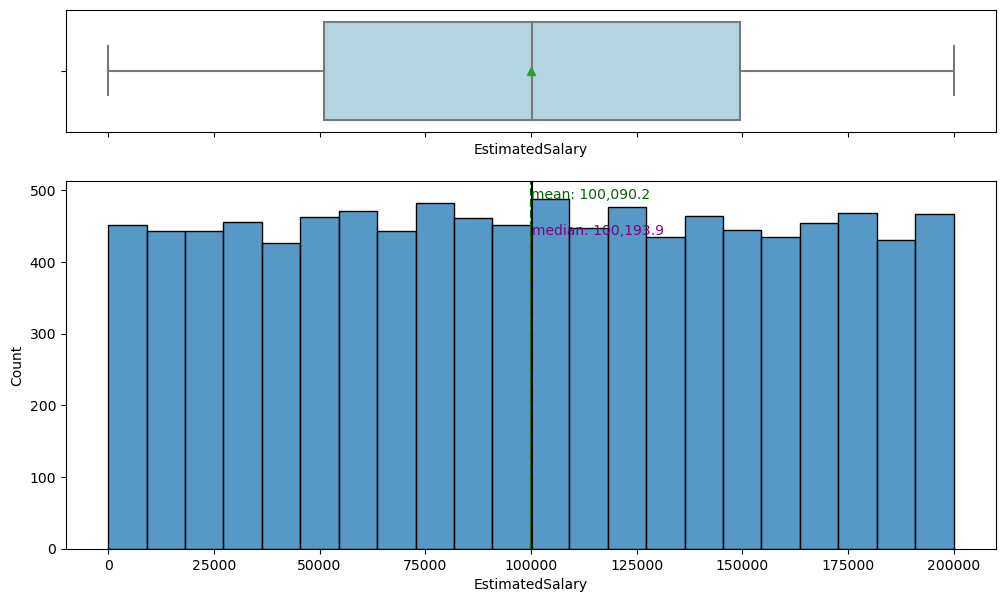

In [18]:
# run histogram_boxplot against numerical data in the dataset
# Estimated Salary
histogram_boxplot(df, 'EstimatedSalary')

In [19]:
# run analysis on categorical data 
col_names = df.columns[:]


for i in col_names:
    if(df[i].dtypes == 'object'):
        print(round(df[i].value_counts(1), 2))
        print('-' * 50)
        print(df[i].value_counts(0))
        print('*' * 50)

Surname
Smith       0.0
Scott       0.0
Martin      0.0
Walker      0.0
Brown       0.0
           ... 
Izmailov    0.0
Bold        0.0
Bonham      0.0
Poninski    0.0
Burbidge    0.0
Name: proportion, Length: 2932, dtype: float64
--------------------------------------------------
Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64
**************************************************
Geography
France     0.50
Germany    0.25
Spain      0.25
Name: proportion, dtype: float64
--------------------------------------------------
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
**************************************************
Gender
Male      0.55
Female    0.45
Name: proportion, dtype: float64
--------------------------------------------------
Gender
Male      5457
Female    4543
Name: count, dtype:

In [20]:
# run analysis on # HasCrCard IsActiveMember  
col_names = ['HasCrCard', 'IsActiveMember']


for i in col_names:
        print(round(df[i].value_counts(1), 2))
        print('-' * 50)
        print(df[i].value_counts(0))
        print('*' * 50)

HasCrCard
1    0.71
0    0.29
Name: proportion, dtype: float64
--------------------------------------------------
HasCrCard
1    7055
0    2945
Name: count, dtype: int64
**************************************************
IsActiveMember
1    0.52
0    0.48
Name: proportion, dtype: float64
--------------------------------------------------
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
**************************************************


### Bivariate Analysis

In [21]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):
    ''' data: dataframe passed to function
        predictor: independent variable
        target: target or dependent variable
    '''

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

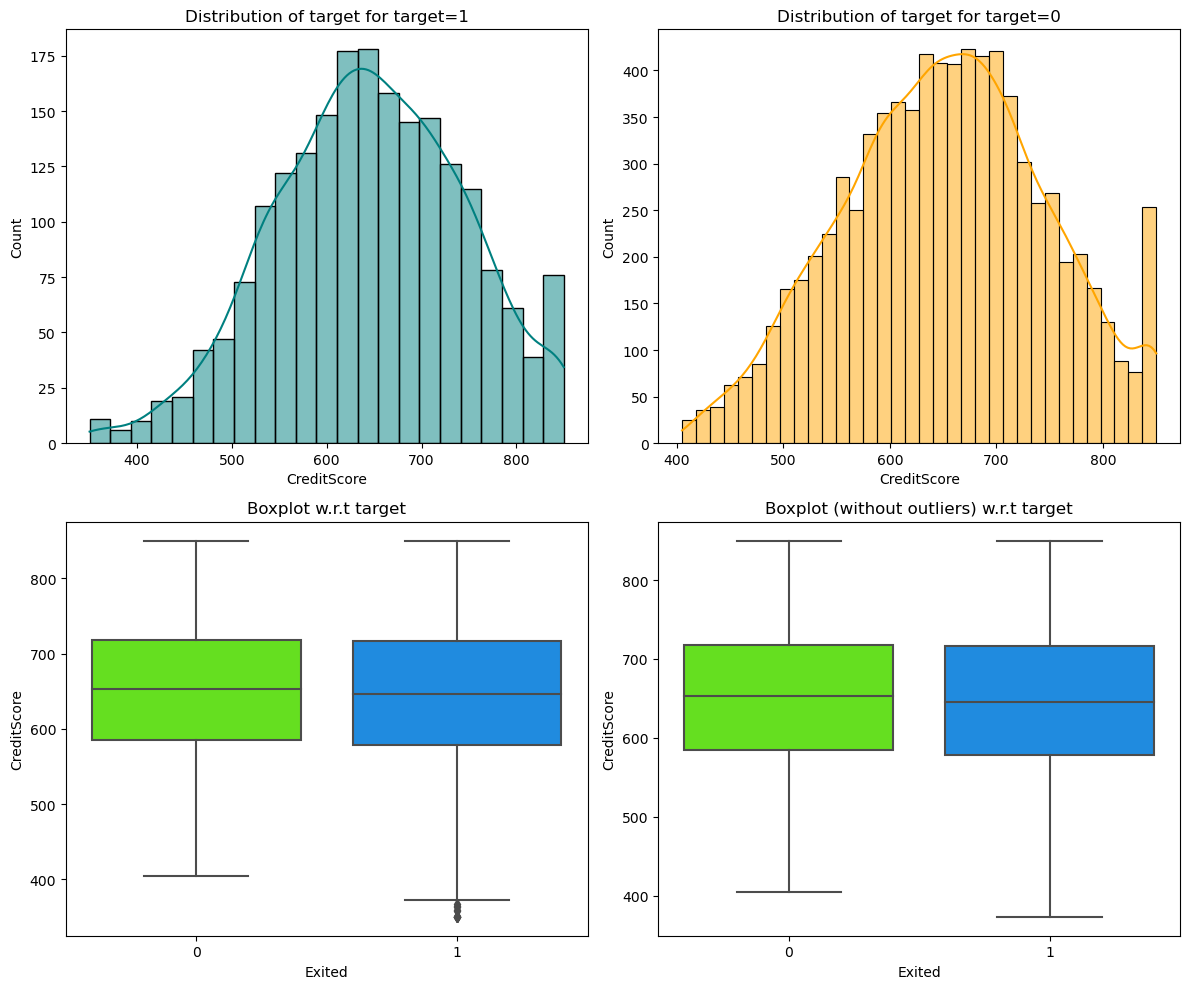

In [22]:
# bivariate analysis on CreditScore and Exit
distribution_plot_wrt_target(df, 'CreditScore', 'Exited')

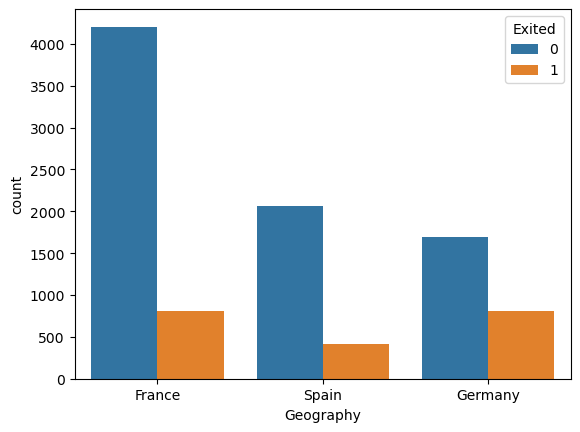

In [23]:
# run countplot on Geography and Exited
sns.countplot(data = df, x = 'Geography', hue = 'Exited')
plt.show()

In [24]:
# count the number of churners per country
df[df['Exited'] == 1].Geography.value_counts()

Geography
Germany    814
France     810
Spain      413
Name: count, dtype: int64

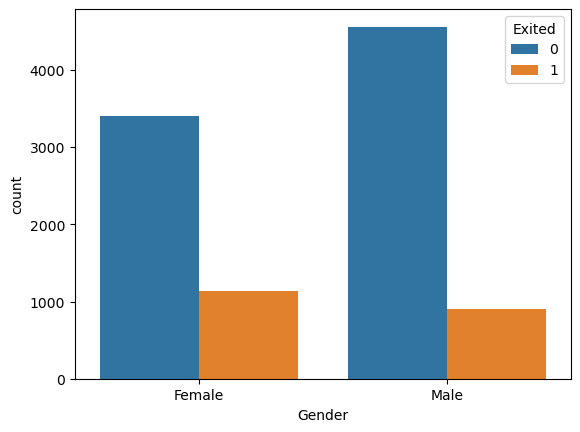

In [25]:
# run countplot on Gender and Exited
sns.countplot(data = df, x = 'Gender', hue = 'Exited')

plt.show()

In [26]:
# count the number of males and femails who have exited
df[df['Exited'] == 1].Gender.value_counts()

Gender
Female    1139
Male       898
Name: count, dtype: int64

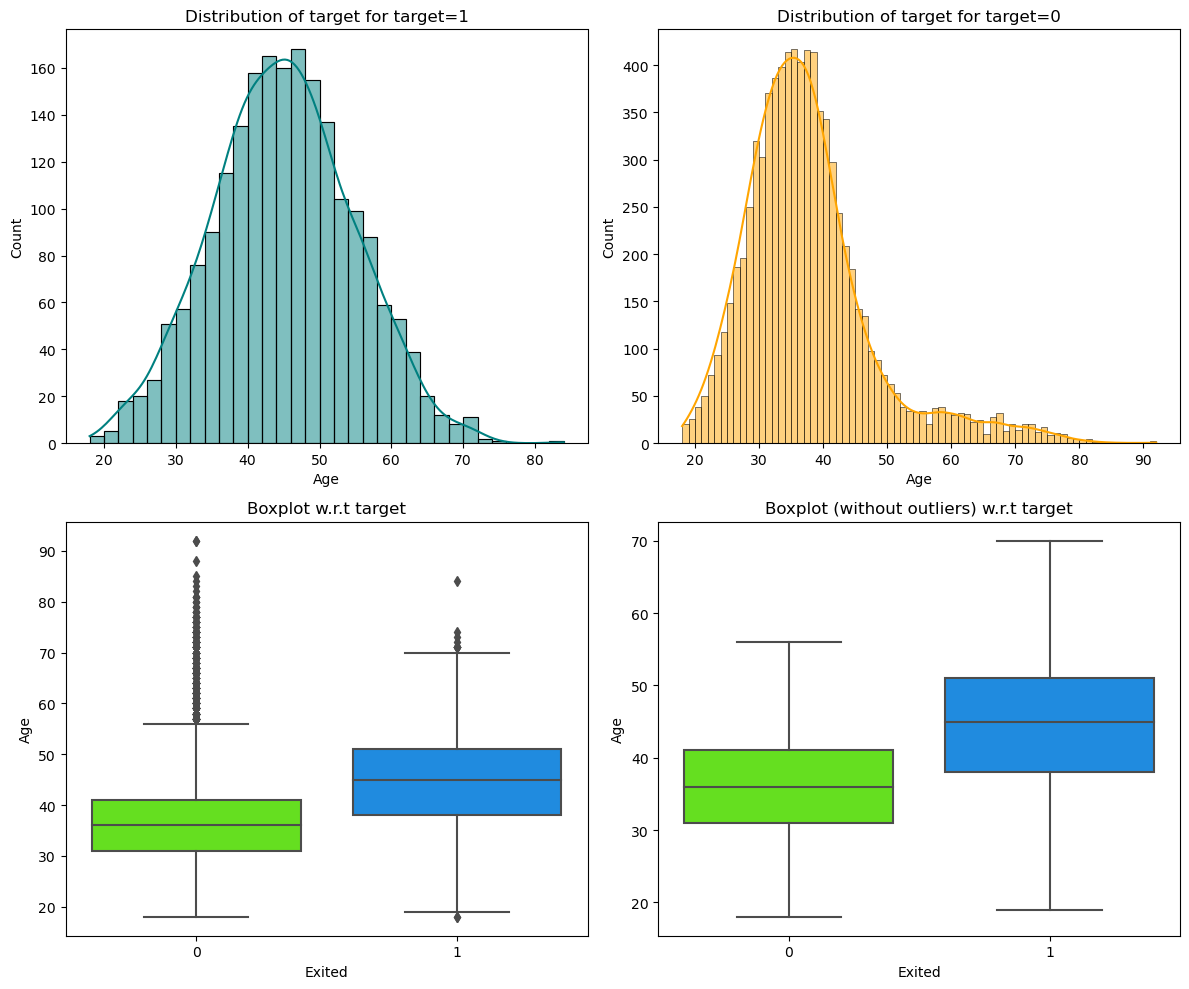

In [27]:
# bivariate analysis on Age and Exited
distribution_plot_wrt_target(df, 'Age', 'Exited')

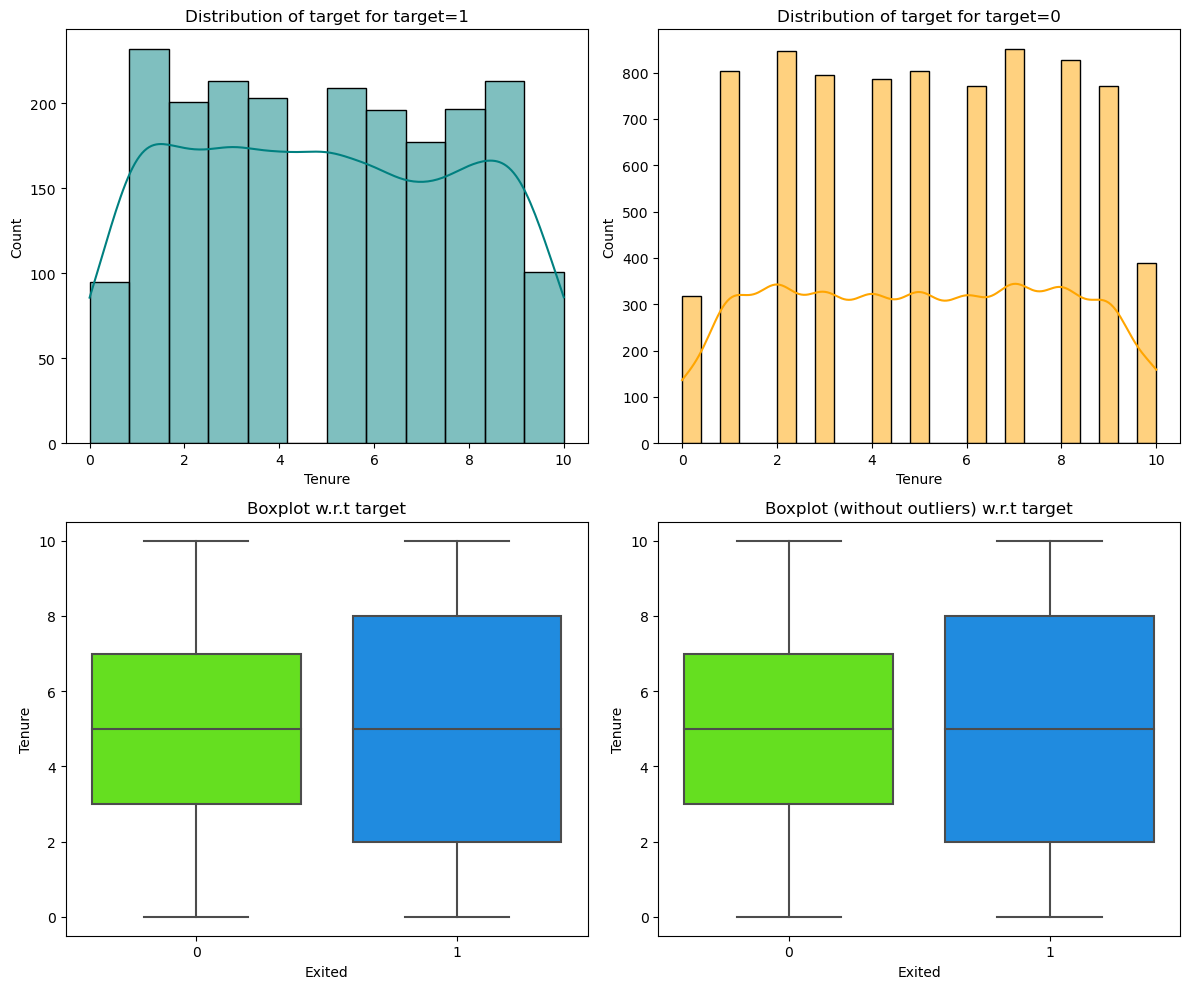

In [28]:
# bivariate analysis on Tenure and Exit
distribution_plot_wrt_target(df, 'Tenure', 'Exited')

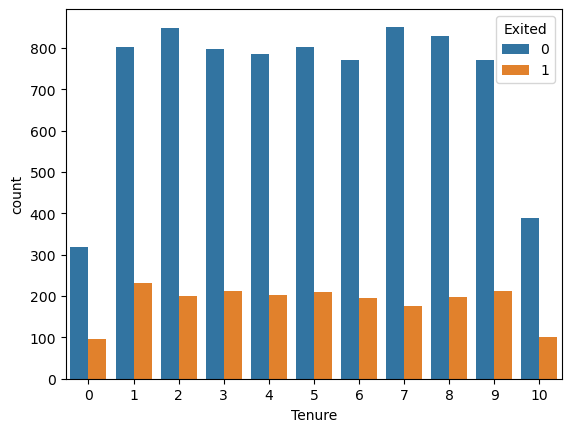

In [29]:
# run countplot on Tenure and Exited
sns.countplot(data = df, x = 'Tenure', hue = 'Exited')
plt.show()

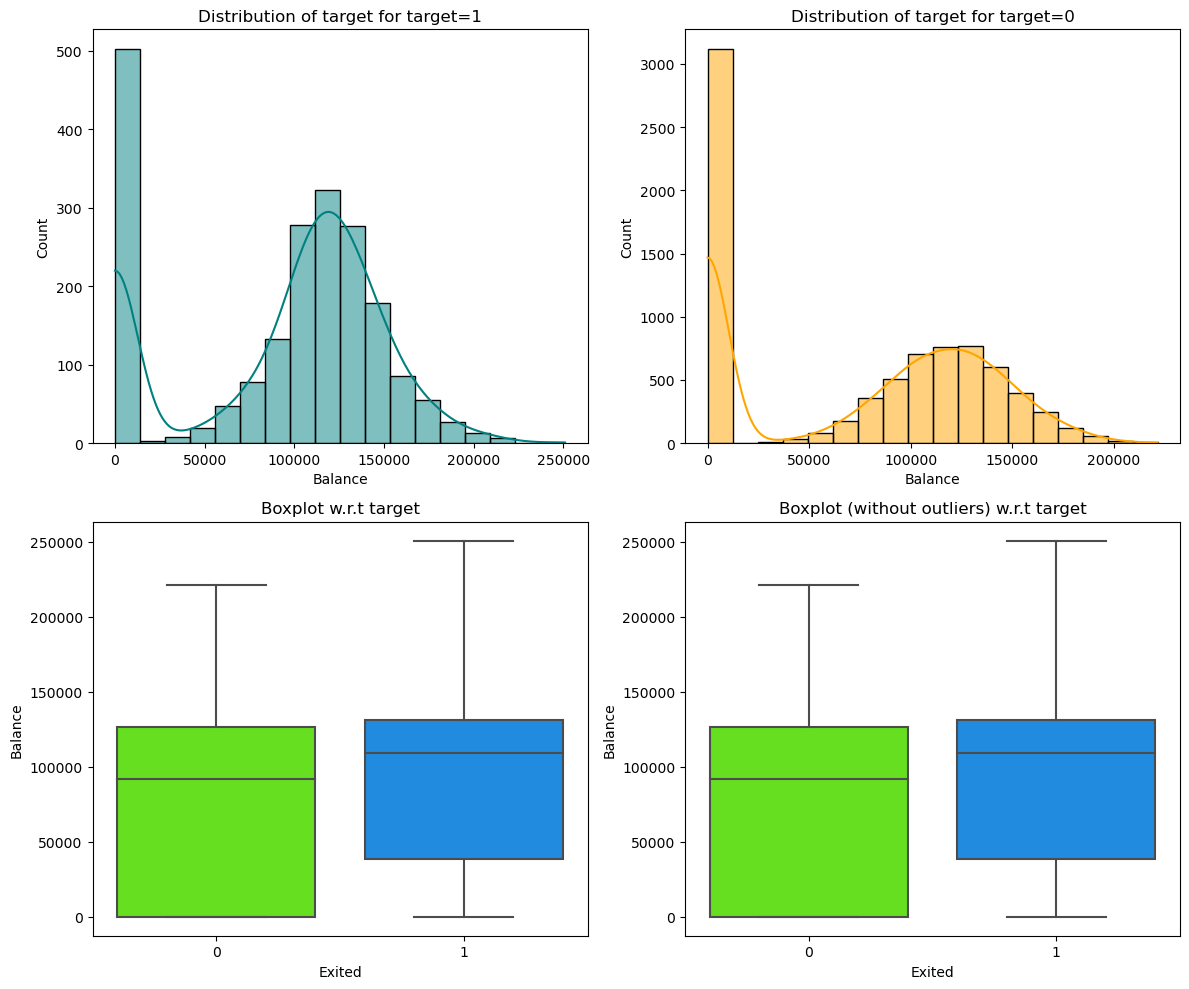

In [30]:
# bivariate analysis on Balance and Exit
distribution_plot_wrt_target(df, 'Balance', 'Exited')

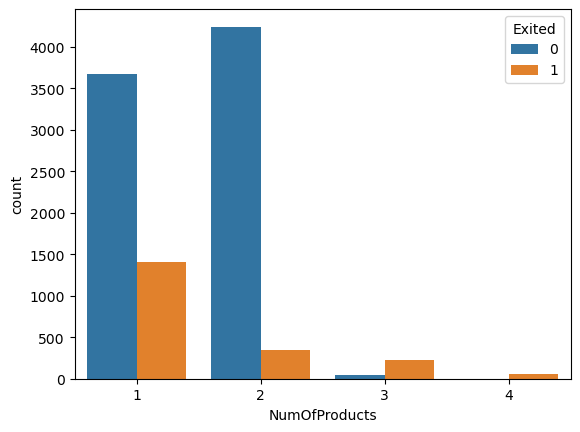

In [31]:
# run countplot on NumOfProducts and Exited
sns.countplot(data = df, x = 'NumOfProducts', hue = 'Exited')
plt.show()

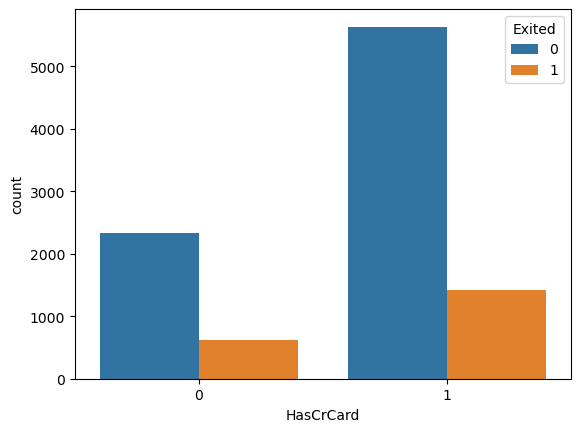

In [32]:
# run countplot on HasCrCard and Exited
sns.countplot(data = df, x = 'HasCrCard', hue = 'Exited')
plt.show()

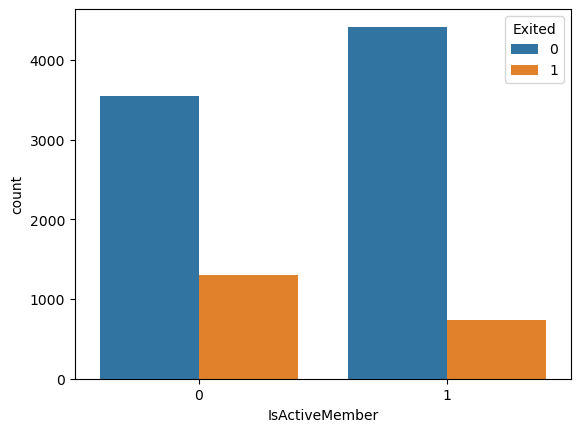

In [33]:
# run countplot on IsActiveMember and Exited
sns.countplot(data = df, x = 'IsActiveMember', hue = 'Exited')
plt.show()

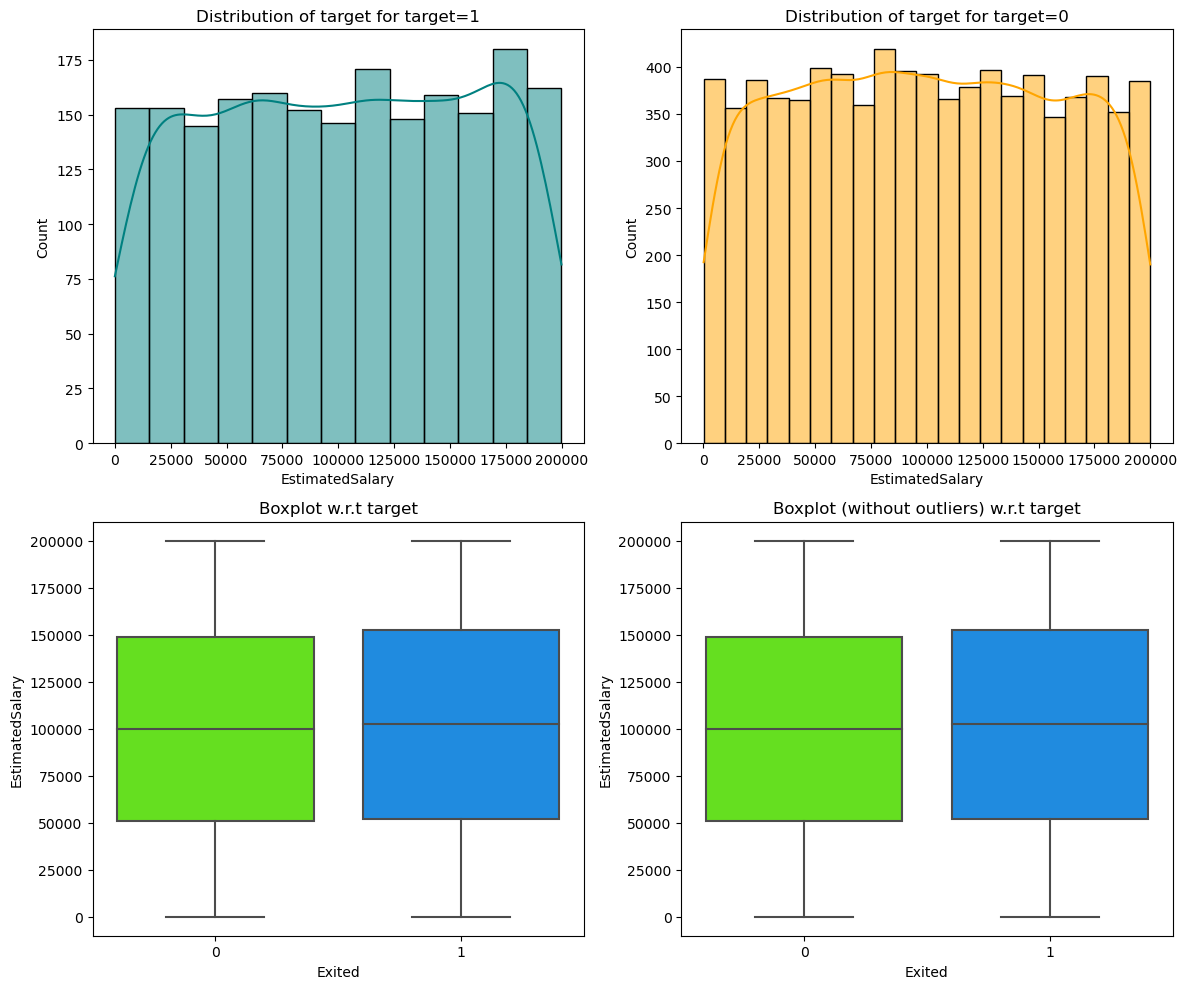

In [34]:
# bivariate analysis on EstimatedSalary and Exit
distribution_plot_wrt_target(df, 'EstimatedSalary', 'Exited')

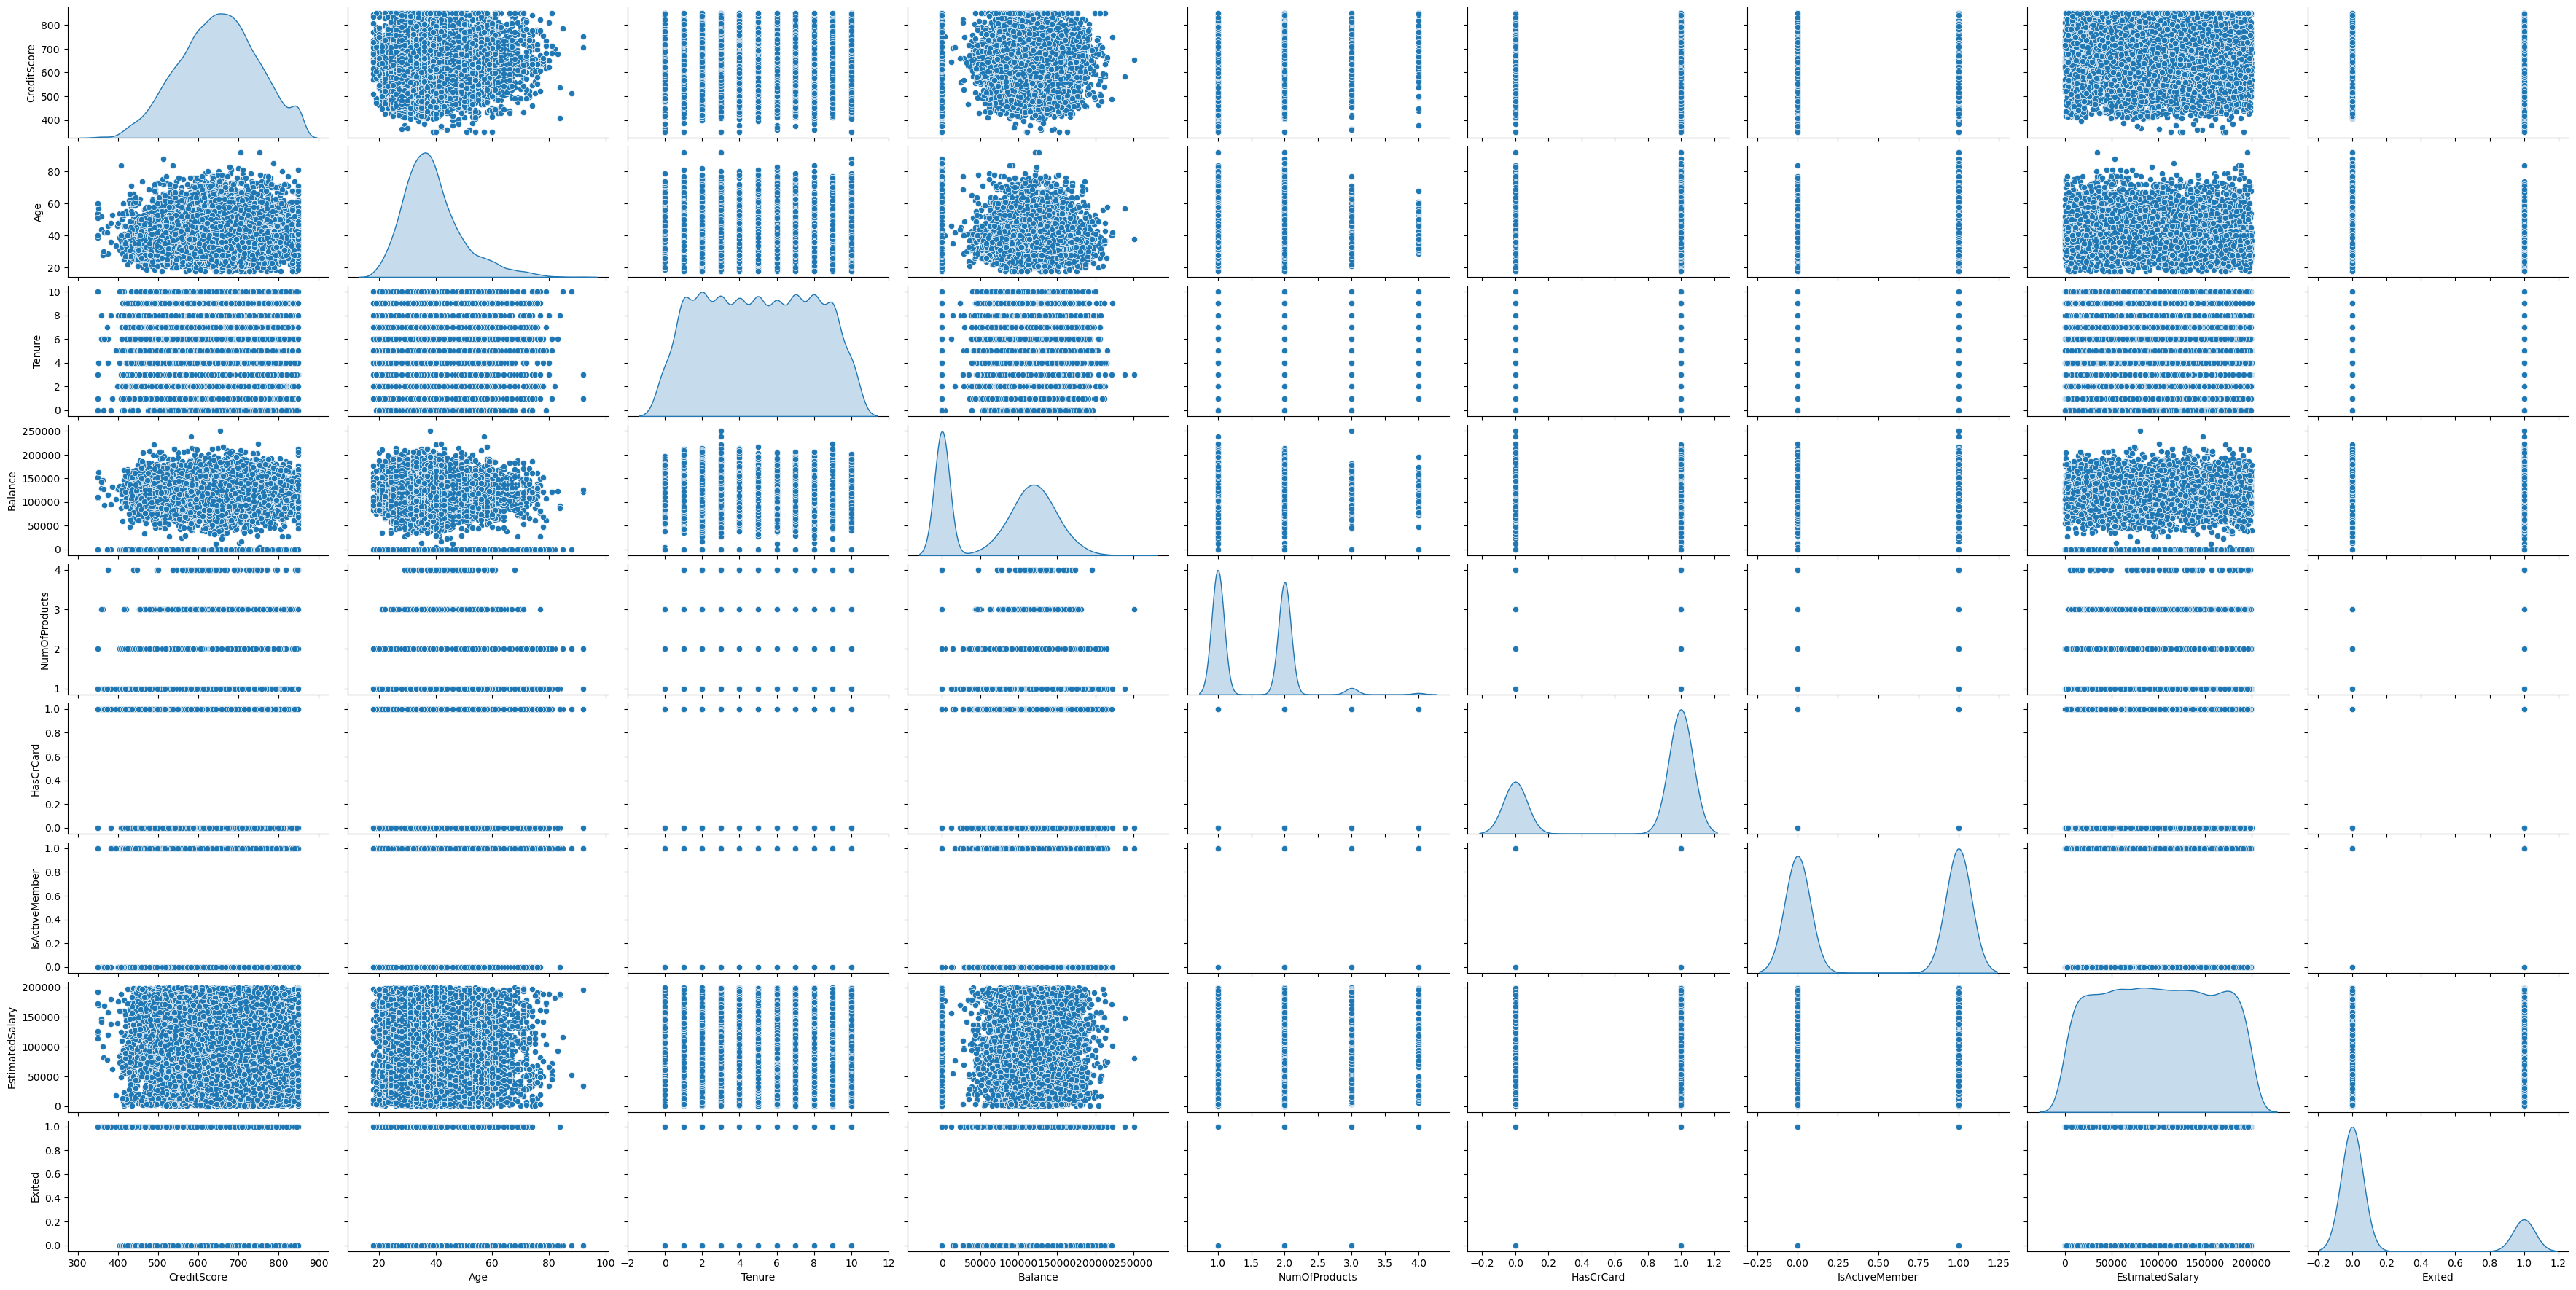

In [35]:
# running pairplot across variables
sns.pairplot(df.iloc[:,2:], height=2,aspect=2 , diag_kind='kde')
plt.show()

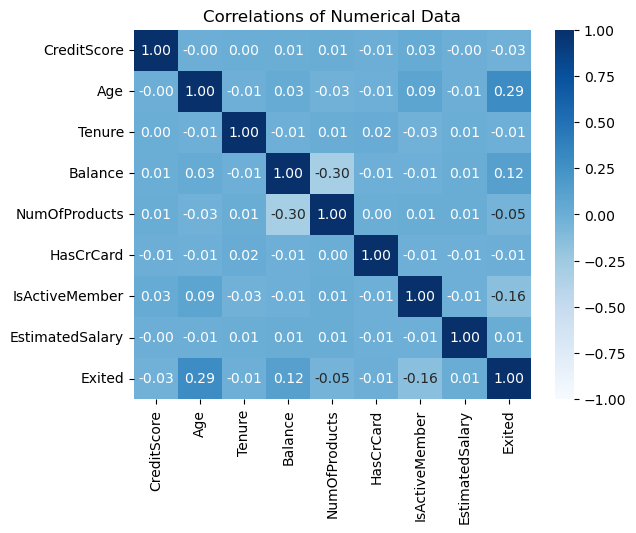

In [36]:
# Run correlation matrix against numerical data

fields = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
         'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

# run corr with sns.heatmap 
#plt.figure(figsize = (10, 10))
sns.heatmap(df[fields].corr(), vmin = -1, vmax = 1, 
            annot = True, cmap = 'Blues', fmt = '.2f')
plt.title('Correlations of Numerical Data')

plt.show()

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

In [464]:
#import standardscaler
# data must be scaled otherwise model over predicts not exiting
from sklearn.preprocessing import StandardScaler

# create variable for continuous variables in dataset
cont_vars = ['EstimatedSalary', 'Balance', 'CreditScore']

# create a scaler
scaler = StandardScaler()

# drop RowNumber, CustomerID, Surname
if('RowNumber' in df.columns):
    df = df.drop('RowNumber', axis = 1)
if('CustomerId' in df.columns):
    df = df.drop('CustomerId', axis = 1)
if('Surname' in df.columns):
    df = df.drop('Surname', axis = 1)
    
df[cont_vars] = scaler.fit_transform(df[cont_vars])

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326221,France,Female,42,2,-1.225848,1,1,1,0.021886,1
1,-0.440036,Spain,Female,41,1,0.117350,1,0,1,0.216534,0
2,-1.536794,France,Female,42,8,1.333053,3,1,0,0.240687,1
3,0.501521,France,Female,39,1,-1.225848,2,0,0,-0.108918,0
4,2.063884,Spain,Female,43,2,0.785728,1,1,1,-0.365276,0


In [465]:
# preparing the data for train_test_split
# store independent variables in X
X = df.drop('Exited', axis = 1)

# store Exited in y
y = df[['Exited']]


In [466]:
# Splitting the dataset into the Training and Testing set.
# Ensure that stratify = True is used

X_train, X_test, y_train, y_test = train_test_split(X,y
                                                , test_size = 0.2
                                                , random_state = 1
                                                , stratify = y)

In [467]:
# encode Geography
from sklearn.preprocessing import LabelEncoder
labelencoder_Geo = LabelEncoder()
X_train['Geography']= labelencoder_Geo.fit_transform(X_train['Geography'])
X_test['Geography']= labelencoder_Geo.transform(X_test['Geography'])

In [468]:
# encode Gender
from sklearn.preprocessing import LabelEncoder
labelencoder_Gen = LabelEncoder()
X_train['Gender']= labelencoder_Geo.fit_transform(X_train['Gender'])
X_test['Gender']= labelencoder_Geo.transform(X_test['Gender'])

In [470]:
###Checking the shape of train and test sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

y_train.value_counts()
y_test.value_counts()

(8000, 10)
(2000, 10)
(8000, 1)
(2000, 1)


Exited
0         1593
1          407
Name: count, dtype: int64

## Model Building

### Model Evaluation Criterion

* ROC-AUC will be used to identify probability splits - classification thresholds
* For output layer, set activation method to sigmoid or softmax
* Set the metric to recall because the dataset is imbalanced
* Also, the cost of misclassifying a churner as a non-churner can be costly

### Model Building: Neural Network

In [490]:
# run this code between model runs
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [491]:
# initialize the ANN
model1 = Sequential()

# add input layer
model1.add(Dense(activation = 'relu', input_dim = X_train.shape[1], units = 256))

# add first hidden layer
model1.add(Dense(activation = 'relu', units = 128))

# add second hidden layer
model1.add(Dense(activation = 'relu', units = 64))

# add third hidden layer
model1.add(Dense(32, activation = 'relu'))

# add the output layer
model1.add(Dense(1, activation = 'sigmoid'))

### Model Building: Neural Network model with Adam Optimizer

In [492]:
# create optimizer with adam, default learning rate
optimizer = tf.keras.optimizers.Adam(0.001)
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= [tf.keras.metrics.Recall()])

In [493]:
# run summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,081
Trainable params: 46,081
Non-trainable params: 0
_________________________________________________________________


In [494]:
# fit the model and verify node config is correct
history1=model1.fit(X_train, y_train,
          validation_split=0.2,
          epochs=50,
          batch_size=32,verbose=1)

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.5223 - recall: 0.0208 - val_loss: 0.4724 - val_recall: 0.1343
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4738 - recall: 0.1019 - val_loss: 0.4610 - val_recall: 0.2060
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4607 - recall: 0.1436 - val_loss: 0.4636 - val_recall: 0.0716
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4552 - recall: 0.1027 - val_loss: 0.4568 - val_recall: 0.0657
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4538 - recall: 0.1382 - val_loss: 0.4497 - val_recall: 0.1582
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4486 - recall: 0.1266 - val_loss: 0.4455 - val_recall: 0.1522
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4415 - recall: 0.1598 - val_loss: 0.4423 - val_recall: 0.1224
Epoch 8/50
200/200 [==============

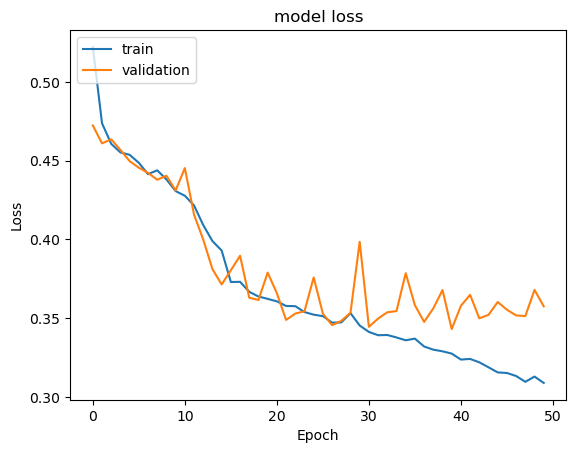

In [495]:
#Plotting Train Loss vs Validation Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.199694, G-Mean=0.772


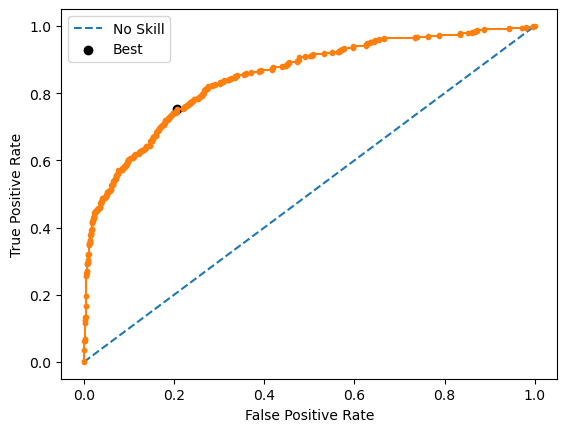

In [496]:
# identify the classification threshold using roc_curve
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat1 = model1.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:,0 ]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [497]:
# run predictions
# key is to set classification threshold using roc curve
# y_pred probability has to be higher than the threshold
y_pred=model1.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred = y_pred.astype(int)



63/63 [==============================] - 0s 1ms/step


In [499]:
# create function to plot a confusion matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)


    if title:
        plt.title(title)

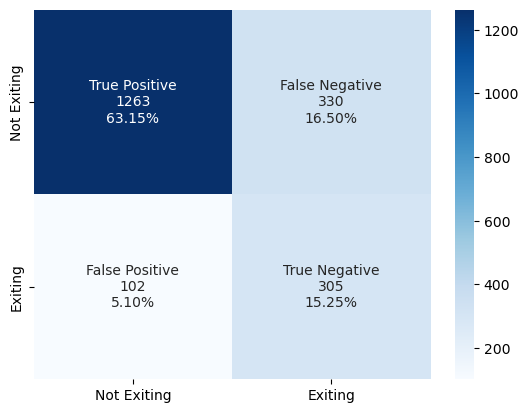

In [500]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Exiting','Exiting']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [501]:
#Accuracy as per the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.75      0.59       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000



### Model Improvement: Neural Network model with Dropout

In [340]:
# run this code between model runs
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [502]:
# initialize the ANN
model2 = Sequential()

# add input layer
model2.add(Dense(activation = 'relu', input_dim = X_train.shape[1], units = 256))

# add dropout
model2.add(Dropout(0.3))

# add first hidden layer
model2.add(Dense(activation = 'relu', units = 128))

# add dropout
model2.add(Dropout(0.3))

# add second hidden layer
model2.add(Dense(activation = 'relu', units = 64))

# add dropout
model2.add(Dropout(0.2))

# add third hidden layer
model2.add(Dense(32, activation = 'relu'))

# add dropout
model2.add(Dropout(0.2))

# add the output layer
model2.add(Dense(1, activation = 'sigmoid'))

In [503]:
# build the model
# create optimizer with adam, default learning rate
optimizer = tf.keras.optimizers.Adam(0.001)
model2.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

In [504]:
# run summary to verify
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [505]:
# fit the model and verify node config is correct
history=model2.fit(X_train, y_train,
          validation_split=0.2,
          epochs=50,
          batch_size=32,verbose=1)

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.6058 - recall_1: 0.0456 - val_loss: 0.5612 - val_recall_1: 0.0000e+00
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5486 - recall_1: 0.0039 - val_loss: 0.5428 - val_recall_1: 0.0000e+00
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5196 - recall_1: 0.0015 - val_loss: 0.5044 - val_recall_1: 0.0000e+00
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4976 - recall_1: 0.0093 - val_loss: 0.4729 - val_recall_1: 0.0000e+00
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4827 - recall_1: 0.0154 - val_loss: 0.4664 - val_recall_1: 0.0000e+00
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4752 - recall_1: 0.0131 - val_loss: 0.4732 - val_recall_1: 0.0000e+00
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4685 - recall_1: 0.0402 - val_loss: 0.4713 - val

63/63 [==============================] - 0s 2ms/step - loss: 0.3631 - recall_1: 0.4496


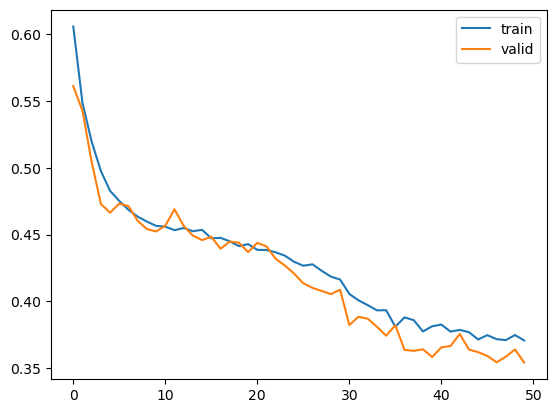

In [506]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = model2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.216025, G-Mean=0.748


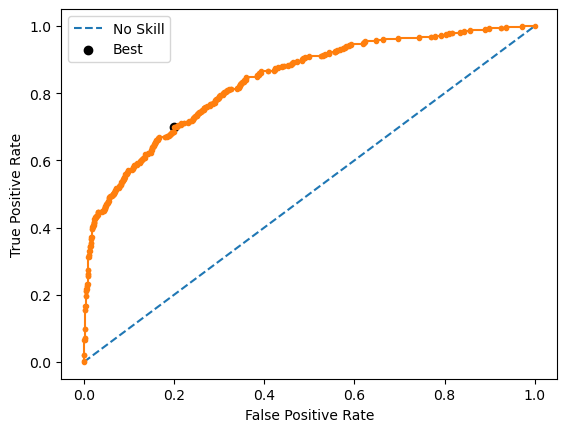

In [507]:
# identify the classification threshold using roc_curve
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat1 = model2.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [508]:
# run predictions
# set classification threshold from roc curve generation
y_pred=model2.predict(X_test)
y_pred = (y_pred > (thresholds1[ix]))

63/63 [==============================] - 0s 1ms/step


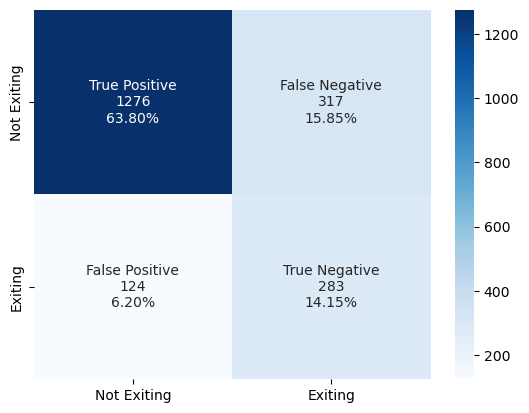

In [509]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Exiting','Exiting']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [510]:
#Accuracy as per the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1593
           1       0.47      0.70      0.56       407

    accuracy                           0.78      2000
   macro avg       0.69      0.75      0.71      2000
weighted avg       0.82      0.78      0.79      2000



### Model Improvement: Neural Network model with Hyperparameter tuning

In [549]:
# run before creating an ANN and model fit
backend.clear_session()
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [550]:
# creating function to capture a tuned learning rate
# continue to use dropout
def create_model_v3(lr,batch_size):
    np.random.seed(1)
    model3 = Sequential()
    model3.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
    model3.add(Dropout(0.3))
    
    model3.add(Dense(128,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.2))
    
    model3.add(Dense(32,activation='relu'))
    model3.add(Dropout(0.2))
    model3.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model3.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model3

In [551]:
# setting batch sizes
# setting learning rate
# applying RandomizedSearchCV
keras_estimator = KerasClassifier(build_fn=create_model_v3, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_distributions=param_random,n_jobs=-1)

In [552]:
# fit the model using output from RandomizedSearchCv
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
200/200 [==============================] - 2s 3ms/step - loss: 0.5553 - accuracy: 0.7869 - val_loss: 0.4704 - val_accuracy: 0.7912
Best: 0.796249 using {'lr': 0.01, 'batch_size': 32}


In [553]:
# apply the best parameters from tuning and run summary
estimator_v3=create_model_v3(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])

estimator_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [554]:
# create adam optimizer using the tuned learning rate
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])

# compile/build model as before
estimator_v3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=[tf.keras.metrics.Recall()])

# create epoch history 
history_3=estimator_v3.fit(X_train, y_train, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 2s 6ms/step - loss: 0.5733 - recall: 0.0309 - val_loss: 0.5206 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4880 - recall: 0.0000e+00 - val_loss: 0.4736 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4760 - recall: 0.0201 - val_loss: 0.4602 - val_recall: 0.0060
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4701 - recall: 0.0247 - val_loss: 0.4591 - val_recall: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4641 - recall: 0.0378 - val_loss: 0.4527 - val_recall: 0.0328
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4634 - recall: 0.0456 - val_loss: 0.4630 - val_recall: 0.0060
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4622 - recall: 0.0641 - val_loss: 0.4590 - val_recall: 0.0000e+00
Epoch 8/50
100

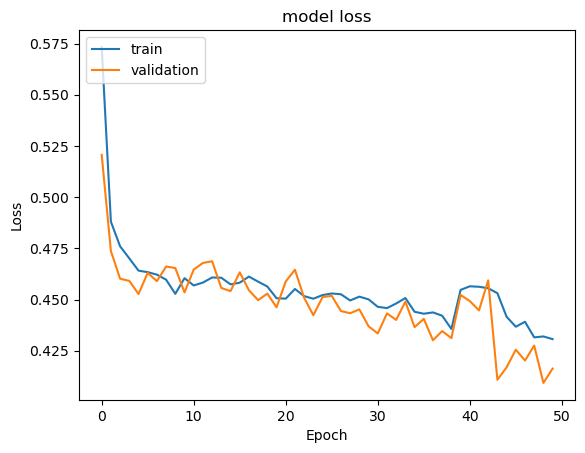

In [555]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.211193, G-Mean=0.730


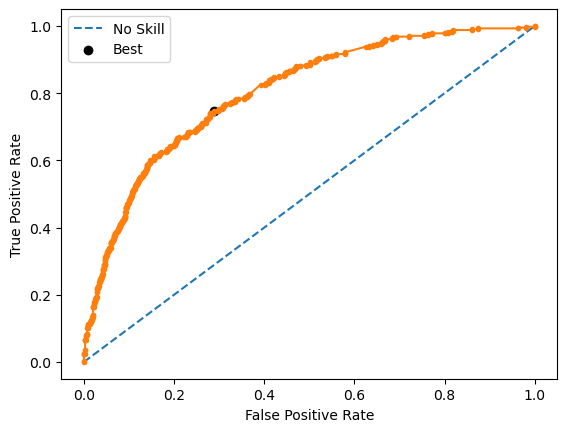

In [556]:
# run roc_curve
# plot roc_curve
# generate and store classification threshold
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat3 = estimator_v3.predict(X_test)
# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]
# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [557]:
# run predictions
# store values greater than classification threshold
y_pred_e3=estimator_v3.predict(X_test)
y_pred_e3 = (y_pred_e3 > thresholds3[ix])

63/63 [==============================] - 0s 1ms/step


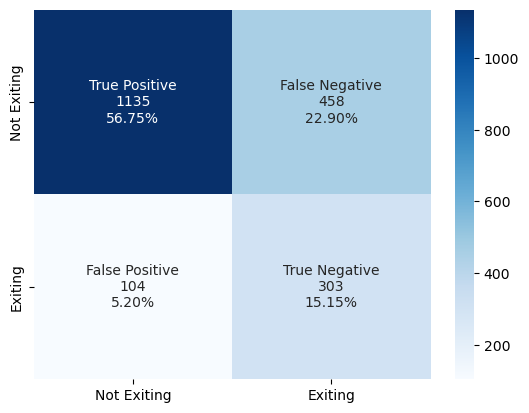

In [558]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_e3)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Exiting','Exiting']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [559]:
#Accuracy as per the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred_e3)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1593
           1       0.40      0.74      0.52       407

    accuracy                           0.72      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.81      0.72      0.74      2000



### Model Improvement: Neural Network model with balanced data

In [560]:
# clear the session before creating ANN and fitting
backend.clear_session()
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [561]:
##Applying SMOTE on train and test
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='not majority')
X_sm , y_sm = smote.fit_resample(X_train,y_train)

In [562]:
# creating function to capture a tuned learning rate
# continue to use dropout
# train on SMOTE data
# model 4
def create_model_v4(lr,batch_size):
    np.random.seed(1)
    model4 = Sequential()
    model4.add(Dense(256,activation='relu',input_dim = X_sm.shape[1]))
    model4.add(Dropout(0.3))
    
    model4.add(Dense(128,activation='relu'))
    model4.add(Dropout(0.3))
    model4.add(Dense(64,activation='relu'))
    model4.add(Dropout(0.2))
    
    model4.add(Dense(32,activation='relu'))
    model4.add(Dropout(0.2))
    model4.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model4.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model4

In [563]:
# setting batch sizes
# setting learning rate
# applying RandomizedSearchCV
keras_estimator = KerasClassifier(build_fn=create_model_v4, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_distributions=param_random,n_jobs=-1)

In [564]:
# fit the model using output from RandomizedSearchCv
# include smote generated values
random_result = random.fit(X_sm, y_sm,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
319/319 [==============================] - 3s 4ms/step - loss: 0.6331 - accuracy: 0.6640 - val_loss: 0.5737 - val_accuracy: 0.7104
Best: 0.446040 using {'lr': 0.01, 'batch_size': 32}


In [565]:
# apply the best parameters from tuning and run summary
estimator_v4=create_model_v4(batch_size=random_result.best_params_['batch_size']
                             ,lr=random_result.best_params_['lr'])

estimator_v4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [566]:
# create adam optimizer using the tuned learning rate
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])

# compile/build model as before
estimator_v4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=[tf.keras.metrics.Recall()])

# create epoch history 
history_4=estimator_v4.fit(X_sm, y_sm, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

Epoch 1/50
160/160 [==============================] - 3s 5ms/step - loss: 0.6965 - recall: 0.1651 - val_loss: 0.6961 - val_recall: 0.5518
Epoch 2/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5688 - recall: 0.4553 - val_loss: 0.5479 - val_recall: 0.7457
Epoch 3/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5512 - recall: 0.4817 - val_loss: 0.8598 - val_recall: 0.3889
Epoch 4/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5438 - recall: 0.5005 - val_loss: 0.6761 - val_recall: 0.6036
Epoch 5/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5393 - recall: 0.4838 - val_loss: 0.4929 - val_recall: 0.7441
Epoch 6/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5380 - recall: 0.4843 - val_loss: 0.6298 - val_recall: 0.6107
Epoch 7/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5291 - recall: 0.5063 - val_loss: 0.6304 - val_recall: 0.6770
Epoch 8/50
160/160 [==============

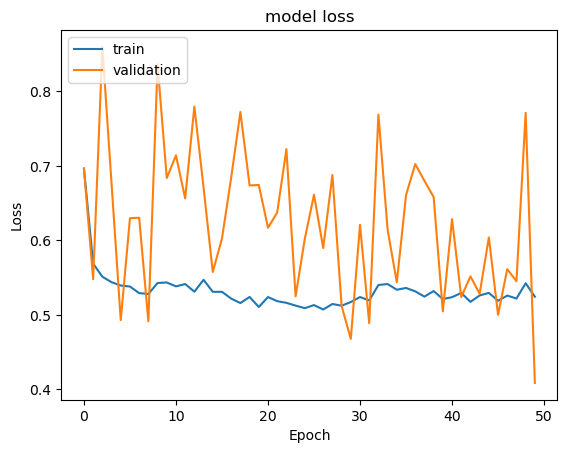

In [567]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.334887, G-Mean=0.712


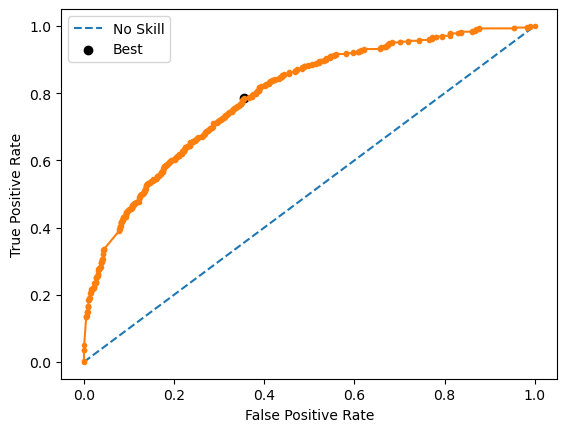

In [599]:
# run roc_curve
# plot roc_curve
# store classification threshold
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat4 = estimator_v4.predict(X_test)
# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]
# calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat4)
# calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [600]:
# run predictions
# store values greater than the classification threshold
y_pred_e4=estimator_v4.predict(X_test)
y_pred_e4 = (y_pred_e4 > thresholds4[ix])

63/63 [==============================] - 0s 1ms/step


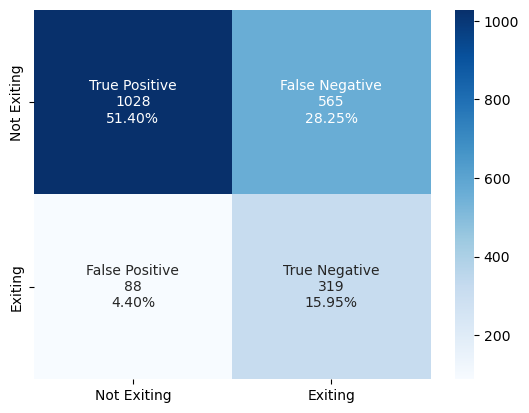

In [601]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_e4)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Exiting','Exiting']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [602]:
#Accuracy as per the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred_e4)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1593
           1       0.36      0.78      0.49       407

    accuracy                           0.67      2000
   macro avg       0.64      0.71      0.63      2000
weighted avg       0.81      0.67      0.71      2000



## Final Model

In [613]:
# run before creating an ANN and model fit
backend.clear_session()
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [614]:
# creating function to capture a tuned learning rate
# continue to use dropout
def create_model_v5(lr,batch_size):
    np.random.seed(1)
    model5 = Sequential()
    model5.add(Dense(256,activation='relu',input_dim = X_sm.shape[1]))
    model5.add(Dropout(0.3))
    
    model5.add(Dense(128,activation='relu'))
    model5.add(Dropout(0.3))
    model5.add(Dense(64,activation='relu'))
    model5.add(Dropout(0.2))
    
    model5.add(Dense(32,activation='relu'))
    model5.add(Dropout(0.2))
    model5.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model5.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model5

In [615]:
# setting batch sizes
# setting learning rate
# applying RandomizedSearchCV
keras_estimator = KerasClassifier(build_fn=create_model_v5, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128, 256],
    "lr":[0.01,0.1,0.001, 0.0001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_distributions=param_random,n_jobs=-1)

In [616]:
# fit the model using output from RandomizedSearchCv
# include smote generated values
random_result = random.fit(X_sm, y_sm,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 3 folds for each of 10 candidates, totalling 30 fits
319/319 [==============================] - 2s 4ms/step - loss: 0.6331 - accuracy: 0.6640 - val_loss: 0.5737 - val_accuracy: 0.7104
Best: 0.467389 using {'lr': 0.01, 'batch_size': 32}


In [617]:
# apply the best parameters from tuning and run summary
estimator_v5=create_model_v5(batch_size=random_result.best_params_['batch_size']
                             ,lr=random_result.best_params_['lr'])

estimator_v5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [618]:
# create adam optimizer using the tuned learning rate
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])

# compile/build model as before
estimator_v5.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=[tf.keras.metrics.Recall()])

# create epoch history 
history_5=estimator_v5.fit(X_sm, y_sm, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

Epoch 1/50
160/160 [==============================] - 2s 5ms/step - loss: 0.6965 - recall: 0.1651 - val_loss: 0.6961 - val_recall: 0.5518
Epoch 2/50
160/160 [==============================] - 1s 4ms/step - loss: 0.5688 - recall: 0.4553 - val_loss: 0.5479 - val_recall: 0.7457
Epoch 3/50
160/160 [==============================] - 1s 4ms/step - loss: 0.5512 - recall: 0.4817 - val_loss: 0.8598 - val_recall: 0.3889
Epoch 4/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5438 - recall: 0.5005 - val_loss: 0.6761 - val_recall: 0.6036
Epoch 5/50
160/160 [==============================] - 1s 4ms/step - loss: 0.5393 - recall: 0.4838 - val_loss: 0.4929 - val_recall: 0.7441
Epoch 6/50
160/160 [==============================] - 1s 4ms/step - loss: 0.5380 - recall: 0.4843 - val_loss: 0.6298 - val_recall: 0.6107
Epoch 7/50
160/160 [==============================] - 1s 4ms/step - loss: 0.5291 - recall: 0.5063 - val_loss: 0.6304 - val_recall: 0.6770
Epoch 8/50
160/160 [==============

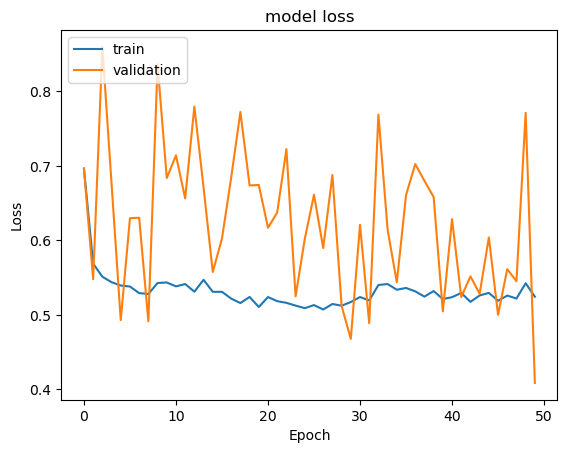

In [619]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.334887, G-Mean=0.712


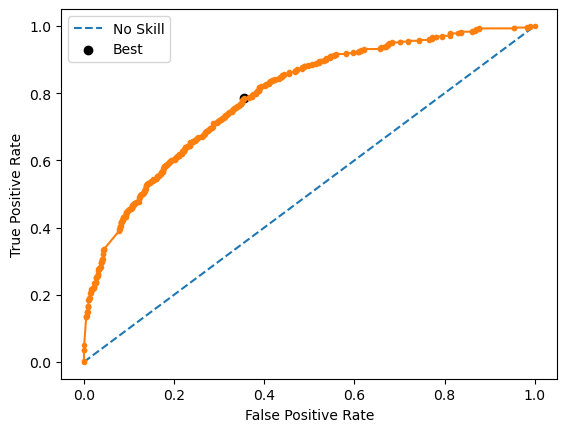

In [620]:
# run roc_curve
# plot roc_curve
# store classification threshold
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat5 = estimator_v5.predict(X_test)
# keep probabilities for the positive outcome only
yhat5 = yhat5[:, 0]
# calculate roc curves
fpr, tpr, thresholds5 = roc_curve(y_test, yhat5)
# calculate the g-mean for each threshold
gmeans5 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans5)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds5[ix], gmeans5[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [621]:
# run predictions
# store values greater than the classification threshold
y_pred_e5=estimator_v5.predict(X_test)
y_pred_e5 = (y_pred_e5 > thresholds5[ix])

63/63 [==============================] - 0s 1ms/step


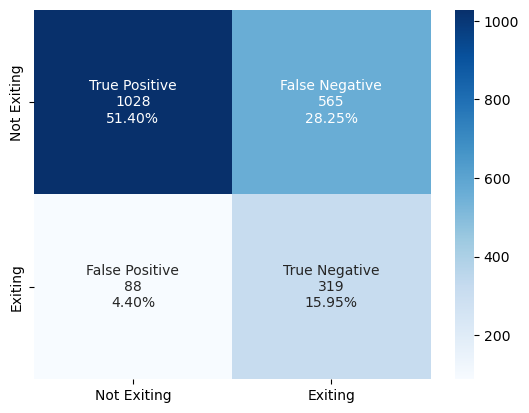

In [622]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_e5)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Exiting','Exiting']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [623]:
#Accuracy as per the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred_e5)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1593
           1       0.36      0.78      0.49       407

    accuracy                           0.67      2000
   macro avg       0.64      0.71      0.63      2000
weighted avg       0.81      0.67      0.71      2000



## Actionable Insights and Recommendations 

**What recommedations would you suggest to the bank?**

* Features must be scaled otherwise ANN models classify all bank customers as non-exiters (0)
* SMOTE and tuning the model can generate better results when optimizing for recall
* Best performing model misses churn under 5% of the time using the Confusion Matrix
* Recall for identifying potential churn is 78%
* This gives the bank a good starting place to understand what is driving exiting customers
* EDA indicates Germany and females churn at higher rates. The Bank should consider retention policies that target these demographics

___